# Using `compyle` for Mandelbrot Set Computation 

Author: Rohan Rajesh Kalbag

Roll Number: 20D170033

### Made use of google colab as `opencl` is not supported by WSL2
Link to Colab Notebook: https://colab.research.google.com/drive/1uNgvBqLrnr3BSrELDZfHMvLqufpmzNWI?usp=sharing
### `mandelbrot_cpu.ipynb` on the other hand was done locally on my computer

In [1]:
! nvidia-smi

Thu Mar 30 21:46:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install pycuda
! pip install pyopencl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!rm -rf data/ && mkdir data
!cd data && git clone https://github.com/pypr/compyle.git
!cd data/compyle && python setup.py install

Cloning into 'compyle'...
remote: Enumerating objects: 2311, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 2311 (delta 206), reused 302 (delta 192), pack-reused 1977
Receiving objects: 100% (2311/2311), 578.53 KiB | 3.62 MiB/s, done.
Resolving deltas: 100% (1347/1347), done.
Compiling compyle/thrust/sort.pyx because it changed.
[1/1] Cythonizing compyle/thrust/sort.pyx
/usr/local/lib/python3.9/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/data/compyle/compyle/thrust/sort.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/usr/local/lib/python3.9/dist-packages/setuptools/dist.py:547: UserWarning: Normalizing '0.9.dev' to '0.9.dev0'
  warnings.warn(tmpl.format(**locals()))
running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWa

In [4]:
! pip install compyle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mandelbrot Set as an `Elementwise` parallel implementation

In [5]:
from compyle.api import annotate, Elementwise, get_config, wrap, declare
import numpy as np
import time
import matplotlib.pyplot as plt

@annotate(int ='i, niter', doublep='x, y', r='intp')
def elementary_mandelbrot(i, x, y, r, niter):
    iters = declare('int')
    iters = 0
    z_x, z_y, z_x_t = declare('double', 3)
    z_x = 0.0
    z_y = 0.0
    z_x_t = 0.0
    xc = x[i]
    yc = y[i]

    while (z_x*z_x + z_y*z_y) < 4.0 and iters < niter:
        z_x_t = z_x*z_x - z_y*z_y + xc
        z_y = 2.0*z_x*z_y + yc
        z_x = z_x_t
        iters += 1

    r[i] = iters

## Trial on OpenMP

In [6]:
nx, ny = 1600, 1200
niter = 20

result = np.ones((nx, ny), dtype=np.int32)*19
x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]

x_flat = x.ravel()
y_flat = y.ravel()
result_flat = result.ravel()
backend = 'cython'
get_config().use_openmp = True
get_config().use_opencl = False
get_config().use_cuda = False

x_flat, yflat, result_flat = wrap(x_flat, y_flat, result_flat, backend=backend)

mandelbrot = Elementwise(elementary_mandelbrot, backend=backend)

# dummy call
mandelbrot(x_flat, y_flat, result_flat, niter)

# actual call
compyle_time = time.perf_counter()
mandelbrot(x_flat, y_flat, result_flat, niter)
compyle_time = time.perf_counter() - compyle_time

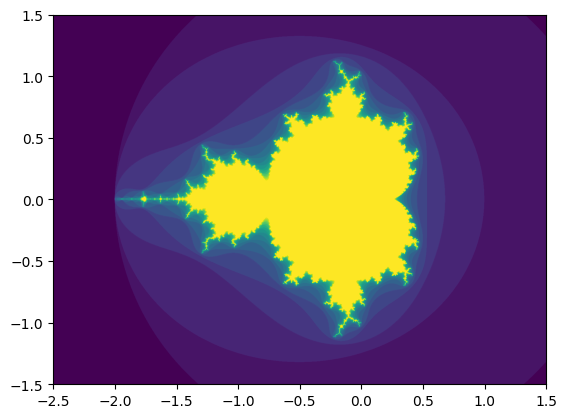

Time taken by openmp: 0.028414246000465937


In [7]:
result = result_flat.data
result.resize((nx, ny))

plt.imshow(result.T, extent=[-2.5, 1.5, -1.5, 1.5])
plt.show()
print("Time taken by openmp:", compyle_time)

## Trial on OpenCL

In [8]:
nx, ny = 1600, 1200
niter = 20

result = np.ones((nx, ny), dtype=np.int32)*19
x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]

x_flat = x.ravel()
y_flat = y.ravel()
result_flat = result.ravel()
backend = 'opencl'
get_config().use_openmp = False
get_config().use_opencl = True
get_config().use_cuda = False

x_flat_opencl, yflat_opencl, result_flat_opencl = wrap(x_flat, y_flat, result_flat, backend=backend)

mandelbrot_opencl = Elementwise(elementary_mandelbrot, backend=backend)

# dummy call
mandelbrot_opencl(x_flat_opencl, yflat_opencl, result_flat_opencl, niter)

# actual call
compyle_time = time.perf_counter()
mandelbrot_opencl(x_flat_opencl, yflat_opencl, result_flat_opencl, niter)
compyle_time = time.perf_counter() - compyle_time

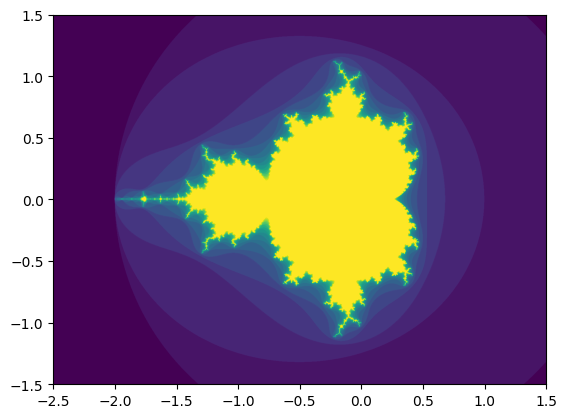

Time taken by opencl: 0.0016912860000957153


In [9]:
result_flat_opencl.pull()
result = result_flat_opencl.data
result.resize((nx, ny))

plt.imshow(result.T, extent=[-2.5, 1.5, -1.5, 1.5])
plt.show()
print("Time taken by opencl:", compyle_time)

## Trial on CUDA

In [10]:
nx, ny = 1600, 1200
niter = 20

result = np.ones((nx, ny), dtype=np.int32)*19
x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]

x_flat = x.ravel()
y_flat = y.ravel()
result_flat = result.ravel()
backend = 'cuda'
get_config().use_openmp = False
get_config().use_opencl = False
get_config().use_cuda = True

x_flat_cuda, yflat_cuda, result_flat_cuda = wrap(x_flat, y_flat, result_flat, backend=backend)

mandelbrot_cuda = Elementwise(elementary_mandelbrot, backend=backend)

# dummy call
mandelbrot_cuda(x_flat_cuda, yflat_cuda, result_flat_cuda, niter)

# actual call
compyle_time = time.perf_counter()
mandelbrot_cuda(x_flat_cuda, yflat_cuda, result_flat_cuda, niter)
compyle_time = time.perf_counter() - compyle_time

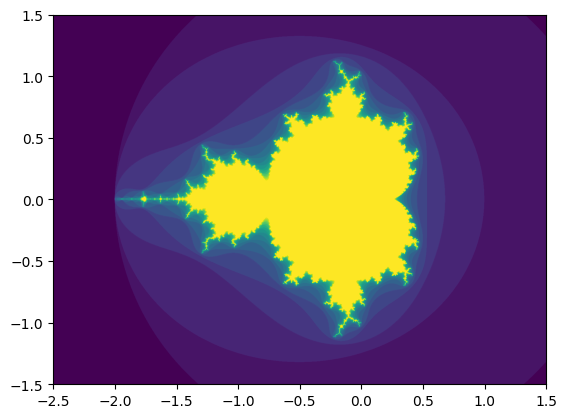

Time taken by cuda: 0.0018300909996469272


In [11]:
result_flat_cuda.pull()
result = result_flat_cuda.data
result.resize((nx, ny))

plt.imshow(result.T, extent=[-2.5, 1.5, -1.5, 1.5])
plt.show()
print("Time taken by cuda:", compyle_time)

# Variation of Iterations with Method (OpenMP, OpenCL, CUDA)

In [12]:
nx, ny = 1600, 1200
niter = [5, 10, 20, 40, 50, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 50000]
times_openmp = []; times_opencl = []; times_cuda = [];

for n in niter:
  # cython openmp
  result = np.ones((nx, ny), dtype=np.int32)*19
  x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]

  x_flat = x.ravel()
  y_flat = y.ravel()
  result_flat = result.ravel()
  backend = 'cython'
  get_config().use_openmp = True
  get_config().use_opencl = False
  get_config().use_cuda = False

  x_flat, yflat, result_flat = wrap(x_flat, y_flat, result_flat, backend=backend)

  compyle_time = time.perf_counter()
  mandelbrot(x_flat, y_flat, result_flat, n)
  compyle_time = time.perf_counter() - compyle_time
  times_openmp.append(compyle_time)
  
  # opencl 
  result = np.ones((nx, ny), dtype=np.int32)*19
  x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]

  x_flat = x.ravel()
  y_flat = y.ravel()
  result_flat = result.ravel()
  backend = 'opencl'

  get_config().use_openmp = False
  get_config().use_opencl = True
  get_config().use_cuda = False

  x_flat_opencl, yflat_opencl, result_flat_opencl = wrap(x_flat, y_flat, result_flat, backend=backend)

  compyle_time = time.perf_counter()
  mandelbrot_opencl(x_flat_opencl, yflat_opencl, result_flat_opencl, n)
  compyle_time = time.perf_counter() - compyle_time
  times_opencl.append(compyle_time)

  # cuda
  result = np.ones((nx, ny), dtype=np.int32)*19
  x, y = np.mgrid[-2.5:1.5:nx*1j, -1.5:1.5:ny*1j]

  x_flat = x.ravel()
  y_flat = y.ravel()
  result_flat = result.ravel()
  backend = 'cuda'

  get_config().use_openmp = False
  get_config().use_opencl = False
  get_config().use_cuda = True

  x_flat_cuda, yflat_cuda, result_flat_cuda = wrap(x_flat, y_flat, result_flat, backend=backend)

  compyle_time = time.perf_counter()
  mandelbrot_cuda(x_flat_cuda, yflat_cuda, result_flat_cuda, n)
  compyle_time = time.perf_counter() - compyle_time
  times_cuda.append(compyle_time)

/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_alloca

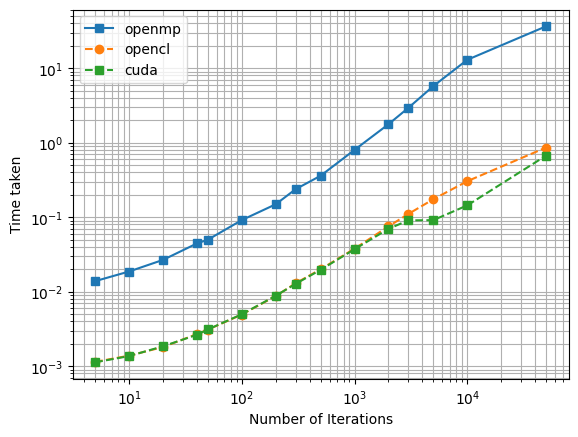

In [13]:
plt.grid(True, which="both", ls="-")
plt.loglog(niter, times_openmp, '-s', label='openmp')
plt.loglog(niter, times_opencl,'--o', label='opencl')
plt.loglog(niter, times_cuda,'--s',label='cuda')
plt.xlabel("Number of Iterations")
plt.ylabel("Time taken")
plt.legend()
plt.show()

We notice that the opencl and cuda nearly perform with similar performance and are nearly a order of magnitude $10^1$ faster than openmp, for a matrix size of 1600 x 1200

# Matrix Size with Method (OpenMP, OpenCL, CUDA)

We keep the ratio of nx and ny fixed to 4:3 in this case

In [16]:
nx = [5, 10, 100, 300, 600, 1000, 1200, 1500, 2000, 3000, 5000, 10000] 
ny = [(3*i)//4 for i in nx]

niter = 20
times_openmp = []; times_opencl = []; times_cuda = [];

for n in range(len(nx)):
  # cython openmp
  result = np.ones((nx[n], ny[n]), dtype=np.int32)*19
  x, y = np.mgrid[-2.5:1.5:nx[n]*1j, -1.5:1.5:ny[n]*1j]

  x_flat = x.ravel()
  y_flat = y.ravel()
  result_flat = result.ravel()
  backend = 'cython'
  get_config().use_openmp = True
  get_config().use_opencl = False
  get_config().use_cuda = False

  x_flat, yflat, result_flat = wrap(x_flat, y_flat, result_flat, backend=backend)

  compyle_time = time.perf_counter()
  mandelbrot(x_flat, y_flat, result_flat, niter)
  compyle_time = time.perf_counter() - compyle_time
  times_openmp.append(compyle_time)
  
  # opencl 
  result = np.ones((nx[n], ny[n]), dtype=np.int32)*19
  x, y = np.mgrid[-2.5:1.5:nx[n]*1j, -1.5:1.5:ny[n]*1j]

  x_flat = x.ravel()
  y_flat = y.ravel()
  result_flat = result.ravel()
  backend = 'opencl'

  get_config().use_openmp = False
  get_config().use_opencl = True
  get_config().use_cuda = False

  x_flat_opencl, yflat_opencl, result_flat_opencl = wrap(x_flat, y_flat, result_flat, backend=backend)

  compyle_time = time.perf_counter()
  mandelbrot_opencl(x_flat_opencl, yflat_opencl, result_flat_opencl, niter)
  compyle_time = time.perf_counter() - compyle_time
  times_opencl.append(compyle_time)

  # cuda
  result = np.ones((nx[n], ny[n]), dtype=np.int32)*19
  x, y = np.mgrid[-2.5:1.5:nx[n]*1j, -1.5:1.5:ny[n]*1j]

  x_flat = x.ravel()
  y_flat = y.ravel()
  result_flat = result.ravel()
  backend = 'cuda'

  get_config().use_openmp = False
  get_config().use_opencl = False
  get_config().use_cuda = True

  x_flat_cuda, yflat_cuda, result_flat_cuda = wrap(x_flat, y_flat, result_flat, backend=backend)

  compyle_time = time.perf_counter()
  mandelbrot_cuda(x_flat_cuda, yflat_cuda, result_flat_cuda, niter)
  compyle_time = time.perf_counter() - compyle_time
  times_cuda.append(compyle_time)

/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.9/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_alloca

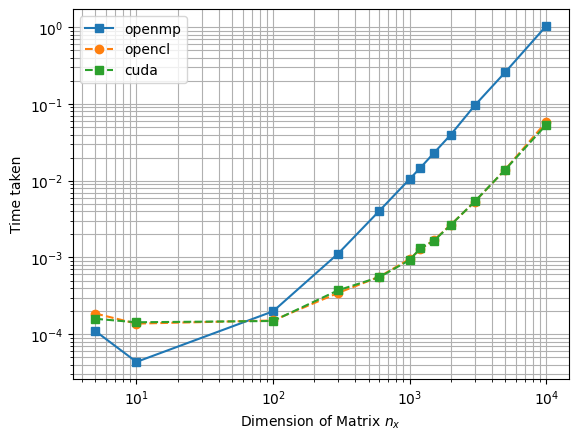

In [17]:
plt.grid(True, which="both", ls="-")
plt.loglog(nx, times_openmp, '-s', label='openmp')
plt.loglog(nx, times_opencl,'--o', label='opencl')
plt.loglog(nx, times_cuda,'--s',label='cuda')
plt.xlabel("Dimension of Matrix $n_x$")
plt.ylabel("Time taken")
plt.legend()
plt.show()

We notice that the opencl and cuda nearly perform with similar performance and are nearly a order of magnitude $10^1$ faster than openmp for larger sizes of $n_x$, meanwhile for smaller sizes of $n_x \le 100$ openmp seems to perform better than opencl and cuda 